# Growth Rate following Stress Simulation

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

Q1: What % difference in growth rate is necessary to detect a change following stress in 120 min?

**Assumptions:**

1. total number of cells is functionally infinite compared to sample being drawn
2. sample size = 10000
3. equal starting conditions pre-stress
4. growth rate following 42&deg;C, 20 min stress is roughly half that of max growth rate in rich media under optimal temperatures (for first pass growth rates will not vary in time).

_[5. Percent error rate of detection/classification is XX]_

In [154]:
# Use this parameter to set the time limits of the experiment (in min!)
recovery_time = 120

t = np.linspace(0,recovery_time,recovery_time+1)
max_growth = np.log(2) / 100
post_stress_growth = max_growth / 2

percent_differences = np.array([0.0001, 0.001, 0.01, 0.1, .2, .5])
#percent_differences = np.array([.5])
ss = post_stress_growth - (post_stress_growth - post_stress_growth*percent_differences)

# This makes an array of arrays - switch to one array with a row for each condition?
predicted_ratio = np.zeros((len(ss), len(t)))

print(len(ss))
print(np.shape(predicted_ratio))

6
(6, 121)


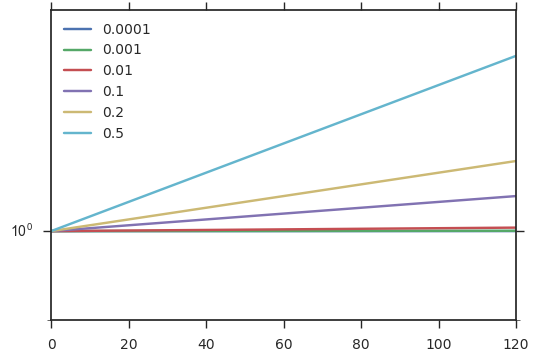

In [161]:
for i, s in enumerate(ss):
    predicted_ratio[i] = np.exp(s*t)

# Convert from odds space to frequency space using r / (1 + r)
predicted_freq = predicted_ratio/(predicted_ratio+1)


f,ax = plt.subplots(figsize = (6,4))
for i, s in enumerate(predicted_ratio):
    ax.plot(t, s, label=str(percent_differences[i]))

ax.set_ylim((.9,1.3))
ax.set_yscale('log')
ax.legend(loc = 'upper left')
plt.show()

Now lets add some sampling noise - we'll simulate this by drawing from a binomial distribution with frequency parameter equal to the frequencies given by the above.

In [162]:
timepoints = [30, 60, 90, 120]
sample_size = 10000

measured_ratios = []
for i, s in enumerate(ss):
    ratios = []
    for time in timepoints:
        p = predicted_freq[i][time]
        sampled_wt = np.asscalar(np.random.binomial(sample_size, p, 1))
        #print(sampled_wt)
        measured_ratio = sampled_wt / (sample_size - sampled_wt)
        #print(measured_ratio)
        ratios.append(measured_ratio)
    measured_ratios.append(ratios)

In [163]:
for i in range(len(measured_ratios)):
    ax.scatter(timepoints, measured_ratios[i])
    
plt.show()